

---



```
Author  
      Name: Stephen Kamau
      Email: stiveckamash@gmail.com
      0705698768.
```



---

## REAL TIME DETECTION MODEL USING YOLO.

- Localization of objects (in this case fire is an object) in photos is a computer vision task normally called `OBJECT DETECTION`
- There are several algorithms for this task i.e `(R-CNN, Region-Based Convolutional Neural Networks), Fast R-CNN,  YOLO (You Only Look Once) and Detectron by FB reseach`
- Yolo is one of the popular and easier one to use for real time object detection.


- For this Demo, the notebook takes us through the the end-to-end object detection project on a custom Fire dataset, using YOLOv5 implementation developed by Ultralytics. `Check on the same Implimentation using YoloV6, and YoloV7(latest yolo models)`.


- Training a Yolo Model is very Easy, the Bigger part comes when the dataset is not in the format required. Yolo expects the labels (Bounding Box Information) to be in a txt format with the same name as the Image.

- The Demo will showcase how to come up with these TXT files for a particular Image as It is the main part for the demo.


--- 

## DATASET.

- For this demo, we will use a dataset composed of images of fire. Annotations for the fire (objects) are in a dataframe format. Most projects have the annnotation is xml files and you need to extract the bounding box information before proceeding to training.
- For your Own Annotation, you can check ROBOFLOW PLATFORM. [CHECK SAMPLE HERE](https://universe.roboflow.com/s-p8sfw/my-datasets-dqlz3)

- Mostly, you are training a model to identify objects or not hence you need to have annotation for each image except the background images (It does not have labels).
-It is also recommended to add up to 10% background images, to reduce false-positives errors. In this demo, i did not have any background image and incase for your test, you can add them.
- Based on yolo docummentation, `Background images are images with no objects that are added to a dataset to reduce False Positives (FP). We recommend about 0-10% background images to help reduce FPs (COCO has 1000 background images for reference, 1% of the total). No labels are required for background images.` : [link](https://github.com/ultralytics/yolov5/issues/2844)


- LET Start...

---

### Importing Required Libs for the Project

- Most of the task will be dealing with files/images and processing the annotations

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

# import som modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm
from glob import glob #extract content from dirs
import shutil, os #making dirs and copy files
import cv2 #image reading/manipulation


import warnings
warnings.filterwarnings("ignore");

In [3]:
# Path to where the data is stored
DATA_DIR ="/content/drive/MyDrive/FIRE"

In [4]:
# read labels
df = pd.read_csv(f"{DATA_DIR}/labels.csv")

In [5]:
# check shape
df.shape

(4562, 8)

In [6]:
# columns
df.columns

Index(['file_id', 'img_name', 'xmax', 'ymax', 'xmin', 'ymin', 'width',
       'height'],
      dtype='object')

In [7]:
# if there is any null
df.isna().sum()

file_id     0
img_name    0
xmax        0
ymax        0
xmin        0
ymin        0
width       0
height      0
dtype: int64

---

### About the Labels.
- As it can be observed, We have variables that can help us draw an Image BBOX. The (XMIN, YMIN) and (XMAX, YMAX) are the two corners for a bbox. The width and Height used is the one in which these annotation were extracted with.


---


Exploring a sample Image with its Bbox information.

In [8]:
# check the number of files we have
df.file_id.nunique()

2187

In [9]:
df.file_id.value_counts()

WEBFire997     5
WEBFire970     5
WEBFire941     5
WEBFire993     5
WEBFire1014    5
              ..
WEBFire1728    1
WEBFire1070    1
WEBFire1218    1
WEBFire1232    1
new_fire_61    1
Name: file_id, Length: 2187, dtype: int64

In [10]:
sample_row = df.iloc[100]
sample_row

file_id         WEBFire977
img_name    WEBFire977.jpg
xmax                   428
ymax                   389
xmin                   376
ymin                   335
width                 1280
height                 720
Name: 100, dtype: object

In [11]:
# select a random image and read it
sample_img = cv2.imread(f"{DATA_DIR}/images/{sample_row.img_name}")

In [12]:
# check shape for the image
sample_img.shape

(720, 1280, 3)

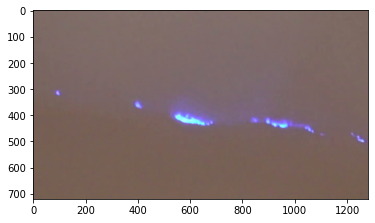

In [13]:
plt.imshow(sample_img, cmap='flare')

In [14]:
# select all records that have same file id as above

df[df['file_id'] == sample_row.file_id]

file_id        img_name  xmax  ymax  xmin  ymin  width  height
100  WEBFire977  WEBFire977.jpg   428   389   376   335   1280     720
101  WEBFire977  WEBFire977.jpg   764   474   462   368   1280     720
102  WEBFire977  WEBFire977.jpg  1173   495   791   387   1280     720
103  WEBFire977  WEBFire977.jpg  1293   522  1211   460   1280     720

In [15]:
anot_img = sample_img.copy()

In [16]:
curr_record = df[df['file_id'] == sample_row.file_id].reset_index(drop=True)
for r in range(curr_record.shape[0]):
  row = curr_record.iloc[r]
  cv2.rectangle(anot_img, (row.xmin, row.ymin), (row.xmax, row.ymax), (255,0, 0),5)

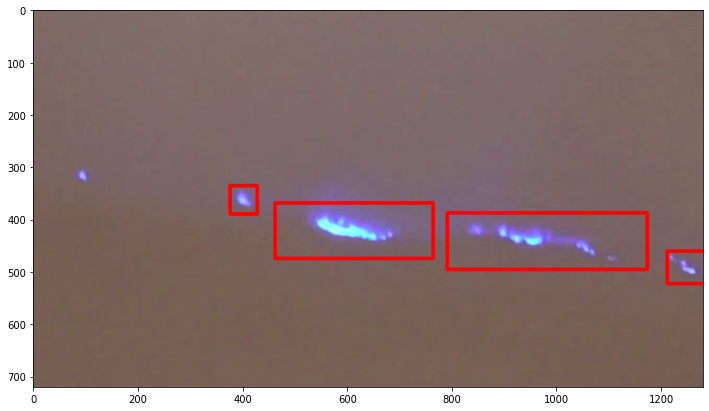

In [17]:
# display the imahge
plt.figure(figsize = (12,12))
plt.imshow(anot_img)

---
- SOme of the most seen fire boxes are encoded using above.

In [18]:
# create a function to do the above.
def Draw_bbox_on_image(img,file_id):
  curr_record = df[df['file_id'] == file_id].reset_index(drop=True)
  drawn_img = img.copy()
  for r in range(curr_record.shape[0]):
    row = curr_record.iloc[r]
    cv2.rectangle(drawn_img, (row.xmin, row.ymin), (row.xmax, row.ymax), (255,0, 0),5)
  return drawn_img

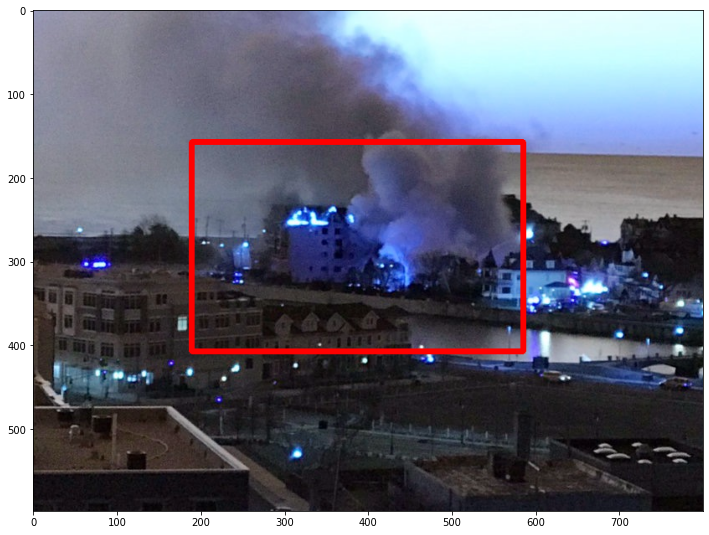

In [19]:
# test the function on a random id

img_1000 = cv2.imread(f"{DATA_DIR}/images/{df.iloc[1000].img_name}")
plt.figure(figsize=(12,12))
plt.imshow(Draw_bbox_on_image(img_1000, df.iloc[1000].file_id))

In [20]:
df[df.file_id == df.iloc[1000].file_id]

file_id img_name  xmax  ymax  xmin  ymin  width  height
1000     406  406.jpg   585   407   189   157    800     598

In [21]:
df_copy = df.copy()

---

### Labelling Format.

- There needs to be one annotations text file per image. Each text file contains one bounding-box (BBox) annotation for each of the objects in the image. The annotations are normalized to the image size, and lie within the range of 0 to 1. They are represented in the following format:
```
< object-class-ID> <X center> <Y center> <Box width> <Box height>
```
- If there are more than one objects in the image, the content of the YOLO annotations text file might look like this:

```
  0 0.563462 0.686216 0.462500 0.195205
  7 0.880769 0.796447 0.041346 0.112586
  2 0.880769 0.796447 0.041346 0.112586
  0 0.564663 0.679366 0.463942 0.181507
  0 0.566106 0.658390 0.469712 0.192637
  1 0.565144 0.359803 0.118750 0.107449
```

- Each Value is sepearated by a space and For Information for each object is on Its new Line.

- Since the annotations needs to be normalized, lets Normalize them and Extyract the `Center and Dimension for Each Fire object`.
- In normalization, the bbox are divided by height if its y else width.
- To get the center, we get sum of either x or y and then divided by 2.
- To get Height and Widht, we subract xmax/ymax by xmin/ymin.




---


- Processing these dimensions is as below

In [22]:
df.columns

Index(['file_id', 'img_name', 'xmax', 'ymax', 'xmin', 'ymin', 'width',
       'height'],
      dtype='object')

In [23]:
# first, normalization of the bbox infromation to be between a range of 1 and 0.
#We divide by height or widht

df['x_min'] = df.apply(lambda record: (record.xmin)/record.width, axis =1)
df['y_min'] = df.apply(lambda record: (record.ymin)/record.height, axis =1)
df['x_max'] = df.apply(lambda record: (record.xmax)/record.width, axis =1)
df['y_max'] = df.apply(lambda record: (record.ymax)/record.height, axis =1)

# extract the Mid point location
df['x_mid'] = df.apply(lambda record: (record.x_max+record.x_min)/2, axis =1)
df['y_mid'] = df.apply(lambda record: (record.y_max+record.y_min)/2, axis =1)

# Extract the height and width of the object
df['w'] = df.apply(lambda record: (record.x_max-record.x_min), axis =1)
df['h'] = df.apply(lambda record: (record.y_max-record.y_min), axis =1)

In [24]:
df.sample()

file_id                img_name  xmax  ymax  xmin  ymin  \
3853  MirrorWEBSmoke2796  MirrorWEBSmoke2796.jpg   428   395   258   199   

      width  height     x_min     y_min     x_max     y_max     x_mid  \
3853    822     617  0.313869  0.322528  0.520681  0.640194  0.417275   

         y_mid         w         h  
3853  0.481361  0.206813  0.317666

In [25]:
df['area'] = df['w']*df['h']
df.head()

file_id          img_name  xmax  ymax  xmin  ymin  width  height  \
0  WEBSmoke1241  WEBSmoke1241.jpg   632   427   508   247   1086     652   
1    WEBFire568    WEBFire568.jpg   891   576     3   214   1000     657   
2    WEBFire568    WEBFire568.jpg   833   388   705   258   1000     657   
3  WEBSmoke1654  WEBSmoke1654.jpg   998   583   704   109    960     640   
4    WEBFire406    WEBFire406.jpg   889   522   439   298   1280     720   

      x_min     y_min     x_max     y_max     x_mid     y_mid         w  \
0  0.467772  0.378834  0.581952  0.654908  0.524862  0.516871  0.114180   
1  0.003000  0.325723  0.891000  0.876712  0.447000  0.601218  0.888000   
2  0.705000  0.392694  0.833000  0.590563  0.769000  0.491629  0.128000   
3  0.733333  0.170313  1.039583  0.910937  0.886458  0.540625  0.306250   
4  0.342969  0.413889  0.694531  0.725000  0.518750  0.569444  0.351563   

          h      area  
0  0.276074  0.031522  
1  0.550989  0.489279  
2  0.197869  0.025327  
3  0.740625  0.226816  
4  0.311111  0.109375

In [26]:
# create a dataframe with n unique files

--- 
### Get all Unique Files with all their Object.
- Since we have a dataframe and a single image can have more than one object, for easier labels creation, lets get all unique files with their objects together on the same record.

- Information regarding the object are going to be inside a list i,e A list of Dictionarys Example for a single File:

```
  [
    {'x_min': 0.4677716390423573, 'y_min': 0.3788, "x_max":0.12435,"y_max":0.234352, "x_mid":0.8829343, "y_mid":0.23435, "w":0.23, "h":0.1234},
    {.....},
    {.....},
    ..........
  ] 
```

In [27]:
# a list to hold all unique files information. It will help in easier convertsiopn to dataframe
TRAIN =[]
for img_id in tqdm(df['file_id'].unique()):
    #get all rows that has the current id
    curr_df = df[df['file_id'] ==img_id].reset_index(drop=True)
    #get unique information
    base_details = dict(curr_df.loc[0][['file_id','img_name', 'width', 'height']])

    # a list to hold bbox annotation information
    information =[]

    #iterate through the whole records of the current id while extracting their annotation informations
    for indx in range(curr_df.shape[0]):
        #get their information as dic and add to the informatiuon list above
        other_details = dict(curr_df.loc[indx][["x_min", "y_min","x_max","y_max", "x_mid", "y_mid", "w", "h", "area" ]])
        information.append(other_details)
    # append information for the current file
    TRAIN.append([base_details['file_id'], base_details['img_name'],base_details['width'],base_details['height'],information])

  0%|          | 0/2187 [00:00<?, ?it/s]

In [28]:
# create a datafrmae from the above created list.
processed_df = pd.DataFrame(TRAIN, columns =['image_id', "img_name", "width", "height", "information"])

In [29]:
# how the current data looks.
processed_df

image_id          img_name  width  height  \
0     WEBSmoke1241  WEBSmoke1241.jpg   1086     652   
1       WEBFire568    WEBFire568.jpg   1000     657   
2     WEBSmoke1654  WEBSmoke1654.jpg    960     640   
3       WEBFire406    WEBFire406.jpg   1280     720   
4       WEBFire547    WEBFire547.jpg   1920    1080   
...            ...               ...    ...     ...   
2182   new_fire_63   new_fire_63.jpg    400     300   
2183   new_fire_53   new_fire_53.jpg    960     640   
2184   new_fire_68   new_fire_68.jpg    740     388   
2185   new_fire_58   new_fire_58.jpg    640     360   
2186   new_fire_61   new_fire_61.jpg   1200     900   

                                            information  
0     [{'x_min': 0.4677716390423573, 'y_min': 0.3788...  
1     [{'x_min': 0.003, 'y_min': 0.3257229832572298,...  
2     [{'x_min': 0.7333333333333333, 'y_min': 0.1703...  
3     [{'x_min': 0.34296875, 'y_min': 0.413888888888...  
4     [{'x_min': 0.4505208333333333, 'y_min': 0.6435...  
...                                                 ...  
2182  [{'x_min': 0.4425, 'y_min': 0.2433333333333333...  
2183  [{'x_min': 0.378125, 'y_min': 0.4390625, 'x_ma...  
2184  [{'x_min': 0.6959459459459459, 'y_min': 0.5824...  
2185  [{'x_min': 0.4109375, 'y_min': 0.5416666666666...  
2186  [{'x_min': 0.7791666666666667, 'y_min': 0.0033...  

[2187 rows x 5 columns]

---
### Train Vs Validation

- We need to Split the data in order to remain with the set for validation after training.
- The validation will be having 10% of ther data while the rest will be training.
- I'm going to divide the data into 10 folds and then select one of the fiold to be used as the validation set.


---

In [30]:
# split into training and validation
gkf  = GroupKFold(n_splits = 10)
processed_df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(gkf.split(processed_df, groups = processed_df.image_id.tolist())):
    processed_df.loc[val_idx, 'fold'] = fold
processed_df.head()

image_id          img_name  width  height  \
0  WEBSmoke1241  WEBSmoke1241.jpg   1086     652   
1    WEBFire568    WEBFire568.jpg   1000     657   
2  WEBSmoke1654  WEBSmoke1654.jpg    960     640   
3    WEBFire406    WEBFire406.jpg   1280     720   
4    WEBFire547    WEBFire547.jpg   1920    1080   

                                         information  fold  
0  [{'x_min': 0.4677716390423573, 'y_min': 0.3788...     1  
1  [{'x_min': 0.003, 'y_min': 0.3257229832572298,...     8  
2  [{'x_min': 0.7333333333333333, 'y_min': 0.1703...     0  
3  [{'x_min': 0.34296875, 'y_min': 0.413888888888...     4  
4  [{'x_min': 0.4505208333333333, 'y_min': 0.6435...     6

In [31]:
processed_df['fold'].value_counts(normalize =True)

1    0.100137
0    0.100137
4    0.100137
6    0.100137
2    0.100137
5    0.100137
3    0.100137
8    0.099680
7    0.099680
9    0.099680
Name: fold, dtype: float64

In [32]:
fold

9

In [33]:
# get all image ids for both training and validation with the bbox

train_fold_files_ids = []
val_fold_files_ids   = []
val_fold_files_ids += list(processed_df[processed_df.fold==fold].image_id.unique())
train_fold_files_ids += list(processed_df[processed_df.fold!=fold].image_id.unique())

In [34]:
len(train_fold_files_ids), len(val_fold_files_ids)

(1969, 218)

In [35]:
# check the directory
!pwd

/content


# Training

### How Data Should Be?.

- The data should be stored in two folders i.,e Images and Labels folder, Inside each, it should also have a sub folder for training and validation/testing.
- Below is how the Structuire should Look.

```
├── data.yaml
base_dir:
├── images
│   ├── train
│   └── validation
└── labels
    ├── train
    └── validation
```


- if you have test, it might look as follows;
```
├── data.yaml
├── test
│   ├── images
│   └── labels
├── train
│   ├── images
│   └── labels
└──  valid
    ├── images
    └── labels
```

- lets Create the above folder structure so as to start transferring data into them.

In [47]:
# create thr directorues as follows
# base_dir
    # images
        # train (contains image files)
        # validation (contains image files)
    # labels 
        # train (contains .txt files)
        # validation (contains .txt files)
        


os.makedirs(f'{DATA_DIR}/yolo/labels/train', exist_ok = True)
os.makedirs(f'{DATA_DIR}/yolo/labels/val', exist_ok = True)
os.makedirs(f'{DATA_DIR}/yolo/images/train', exist_ok = True)
os.makedirs(f'{DATA_DIR}/yolo/images/val', exist_ok = True)

In [48]:
sample_d = processed_df[processed_df['image_id']== train_fold_files_ids[0]]
sample_d

image_id          img_name  width  height  \
0  WEBSmoke1241  WEBSmoke1241.jpg   1086     652   

                                         information  fold  
0  [{'x_min': 0.4677716390423573, 'y_min': 0.3788...     1

---
### Process Data.

- Here we input required images with their labels to the above folders.
- For labels, as stated above, we create atxt file with
```
      class x-center y-center width height
```
- Images will be moved from the folder where they are to either Training or validation folder while creating labels for the same.

--- 

Below is the Implimentation of the above

In [49]:
YOLO_IMGS_DIR = "/content/drive/MyDrive/FIRE/yolo/images/"
YOLO_LBL_DIR = "/content/drive/MyDrive/FIRE/yolo/labels/"

In [39]:
IMG_DIRS = "/content/drive/MyDrive/FIRE/images"

In [40]:
for xq in  sample_d['information'].values[0]:
    print(0, xq['x_mid'], xq['y_mid'], xq['w'] , xq['h'])

0 0.5248618784530387 0.5168711656441718 0.11418047882136273 0.27607361963190186


In [54]:
"""
In this cell, It is a function that iterates through each row in the df
It first determine whether the image belows to training or testing sets.

 For each image:
    1- get the info for each bounding box
    2- write the bounding box info to a txt file
    3- save the txt file in the correct folder
    4- copy the image to the correct folder

Before saving the image, it must be processed by applying clahe function/
class, center (x,y), width, height

Also the format for YOLO dataset is followed i.e
"""

def process_data_for_yolo(df, file_id_lists, data_type='train'):
    """
    Reads details for an image and transfers them to their respective folders when proceesed.
    """
    #iterate through each row
    #for _, row in notebook.tqdm(df.iterrows(), total=len(df)):
    for each_id in tqdm(file_id_lists, total=len(file_id_lists)):
        #print(each_id, file_id_lists)
        row = df.loc[each_id]
        
        #get img information
        file_id = row['image_id']
        file_name = row['img_name']
        # Convert into the Yolo input format
        yolo_data = []
        for xq in  row['information']:
            curr_bbox_infor = [0, xq['x_mid'], xq['y_mid'], xq['w'] , xq['h']]
            if xq['x_mid']<=0 and  xq['y_mid']<=0 and xq['w']<=0 and xq['h']<=0:
                pass
            else:
                yolo_data.append(curr_bbox_infor)

        # convert to nump array
        yolo_data = np.array(yolo_data)
        #print(yolo_data)
        #copy image to another directory where training will occur
        full_file_path = f"{IMG_DIRS}/{file_name}"
        shutil.copy(full_file_path, f'{YOLO_IMGS_DIR}{data_type}')
        
        #saved format must be class, center (x,y), width, heihgt 
        np.savetxt(os.path.join(f"{YOLO_LBL_DIR}/{data_type}/{file_id}.txt"),
                                yolo_data, 
                                fmt=["%d", "%f", "%f", "%f", "%f"]
                   )

In [55]:
# since we using Id to create the data, lets set index as file id.
indexed_train = processed_df.copy()
indexed_train.index = processed_df['image_id']

In [56]:
# process training
process_data_for_yolo(indexed_train, train_fold_files_ids, 'train')

# process testing
process_data_for_yolo(indexed_train, val_fold_files_ids, 'val')

  0%|          | 0/1969 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

In [57]:
# check the size of trainig
len(glob(f"{YOLO_IMGS_DIR}/train/*")), len(glob(f"{YOLO_LBL_DIR}/train/*"))

(1969, 1969)

In [58]:
# size of validation images
len(glob(f"{YOLO_IMGS_DIR}/val/*")), len(glob(f"{YOLO_LBL_DIR}/val/*"))

(218, 218)

In [59]:
# change directory to where the model for yolo will be stored.
os.chdir("/content/drive/MyDrive/FIRE/yolo/")

# print current wrking directory
!pwd

/content/drive/MyDrive/FIRE/yolo


---

### Training Config Files

- There are 3 config files types present in YAML format. When the repo  (Ultralyric) is cloned all of these are download. We are going to only customize one of them whihc will contain information about our training dataset. These config types include;

  1. The Data Config File- Describes the dataset to be used. It contains information such as;
   - The paths to the train, validation and test (optional) datasets;
   - The number of classes (nc); 
   - The names of these classes in the same order as their index. For this demo, We only have one class Callled FIRE with index 0. You des not need to include the class for backgroudn Data. The content of this YAML file is as follow:

  2. The Model Config File - Shows the model Architecture. Ultralytics supports several YOLOv5 architectures, named P5 models, which varies mainly by their parameters size. They Include 
      - YOLOv5n (nano) 
      - YOLOv5s (small), 
      - YOLOv5m (medium), 
      - YOLOv5l (large), 
      - YOLOv5x (extra large). 

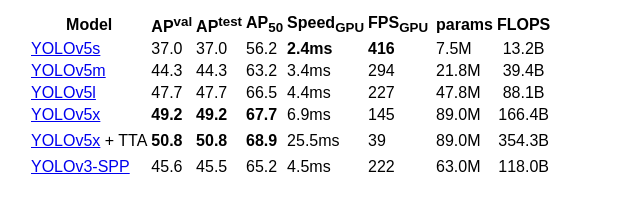


  - There are other P6 models which supports even large dimensiion more that 640px as incase of P5. We are not going to edit any of these files config but we are going to use `YOLOv5x as out initial weights`.

  3. The hyperparameters Configs - Defines the hyperparameters for the training, including the learning rate, momentum, losses, augmentations etc. Ultralytics provides a default hyperparameters file under the ‘data/hyp/hyp.scratch.yaml’ directory. The YAML configuration files are nested at the directory defing 3 default paramers for `large, medium and low`: We are going to user default hyperparameters hence no need to edit them.



- Lets Create Data Config File containing paths and classes information. For the path, you can point to the base directoy with trainign and validation images or point to a txt file containing the paths for these images.


In [60]:
# save the data (labels and images directories into a txt file)
with open(os.path.join( "/content/drive/MyDrive/FIRE/yolo/" , 'train.txt'), 'w') as f:
    for path in glob('/content/drive/MyDrive/FIRE/yolo/images/train/*'):
        f.write(path+'\n')

with open(os.path.join( "/content/drive/MyDrive/FIRE/yolo/" , 'val.txt'), 'w') as f:
    for path in glob("/content/drive/MyDrive/FIRE/yolo/images/val/*"):
        f.write(path+'\n')

In [61]:
# example of files stored
open(os.path.join( "/content/drive/MyDrive/FIRE/yolo/" , 'val.txt'), 'r+').read().split("\n")[:10]

['/content/drive/MyDrive/FIRE/yolo/images/val/WEBFire550.jpg',
 '/content/drive/MyDrive/FIRE/yolo/images/val/WEBFire954.jpg',
 '/content/drive/MyDrive/FIRE/yolo/images/val/WEBFire2047.jpg',
 '/content/drive/MyDrive/FIRE/yolo/images/val/WEBFire1909.jpg',
 '/content/drive/MyDrive/FIRE/yolo/images/val/WEBFire2056.jpg',
 '/content/drive/MyDrive/FIRE/yolo/images/val/WEBFire595.jpg',
 '/content/drive/MyDrive/FIRE/yolo/images/val/WEBFire324.jpg',
 '/content/drive/MyDrive/FIRE/yolo/images/val/WEBFire360.jpg',
 '/content/drive/MyDrive/FIRE/yolo/images/val/WEBFire312.jpg',
 '/content/drive/MyDrive/FIRE/yolo/images/val/WEBFire537.jpg']

```

         'train': <path to train data>,
         'val': <path to val data>,
         'nc': 5,
         'names': ['label0', 'label1', 'label2', 'label3', 'label4']}

```

In [62]:
# information to be used as daata by yolo

yolo_data = dict(
    train =  os.path.join( "/content/drive/MyDrive/FIRE/yolo/" , 'train.txt') ,
    val   =  os.path.join( "/content/drive/MyDrive/FIRE/yolo/", 'val.txt' ),
    nc    = 1,# there is only one class
    names = ["Fire"]
    )
yolo_data

{'train': '/content/drive/MyDrive/FIRE/yolo/train.txt',
 'val': '/content/drive/MyDrive/FIRE/yolo/val.txt',
 'nc': 1,
 'names': ['Fire']}

In [63]:
# save the file as yaml with the information
import yaml
with open(os.path.join( "/content/drive/MyDrive/FIRE/yolo/" , 'fire.yaml'), 'w') as outfile:
    yaml.dump(yolo_data, outfile, default_flow_style=False)

In [64]:
# recheck
filler = open(os.path.join("/content/drive/MyDrive/FIRE/yolo/" , 'fire.yaml'), 'r')

print(filler.read())

names:
- Fire
nc: 1
train: /content/drive/MyDrive/FIRE/yolo/train.txt
val: /content/drive/MyDrive/FIRE/yolo/val.txt



### Clone UltraLytics YOloV5 repo.

In [65]:
# """"
# clone yolo repor
!git clone https://github.com/ultralytics/yolov5.git 

Cloning into 'yolov5'...
remote: Enumerating objects: 14468, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 14468 (delta 7), reused 10 (delta 4), pack-reused 14446
Receiving objects: 100% (14468/14468), 13.46 MiB | 8.57 MiB/s, done.
Resolving deltas: 100% (9980/9980), done.


In [66]:
!pwd

/content/drive/MyDrive/FIRE/yolo


In [67]:
# move to the directory with downloaded code
%cd /content/drive/MyDrive/FIRE/yolo/yolov5

/content/drive/MyDrive/FIRE/yolo/yolov5


In [68]:
# install the requirements.txt
%pip install -qr requirements.txt

     |████████████████████████████████| 1.6 MB 44.1 MB/s eta 0:00:01


In [69]:
import torch

print('Torch -v %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Torch -v 1.12.1+cu113 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


### COnfigure WANDB 
- Weaghts and Biases will be tracked by these platform.
- It helps in models and metric versionning.

In [71]:
# login to wandb.
!pip install wandb -qq
import wandb

     |████████████████████████████████| 1.9 MB 30.3 MB/s 
     |████████████████████████████████| 182 kB 71.5 MB/s 
     |████████████████████████████████| 166 kB 68.3 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 166 kB 66.7 MB/s 
     |████████████████████████████████| 162 kB 65.3 MB/s 
     |████████████████████████████████| 162 kB 81.3 MB/s 
     |████████████████████████████████| 158 kB 77.9 MB/s 
     |████████████████████████████████| 157 kB 79.0 MB/s 
     |████████████████████████████████| 157 kB 77.8 MB/s 
     |████████████████████████████████| 157 kB 72.8 MB/s 
     |████████████████████████████████| 157 kB 79.9 MB/s 
     |████████████████████████████████| 157 kB 77.3 MB/s 
     |████████████████████████████████| 157 kB 76.0 MB/s 
     |████████████████████████████████| 157 kB 74.1 MB/s 
     |████████████████████████████████| 156 kB 80.4 MB/s 


In [72]:
# login
wandb.login()


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [73]:
# project name
wandb.init(project="DevFest")

wandb: Currently logged in as: stephenkamau. Use `wandb login --relogin` to force relogin


### Starting Training.
- We pass the data and model weights to be used to train.py file as arguments.

What some of the parameters passed and what are they used for?:
- Arguments to be passed oinclude;


    1. --weights => the pre-trained model that we are using.
    The list of available pre-trained models can be found here:
    https://github.com/ultralytics/yolov5

    2. --save-txt => The predicted bbox coordinates get saved to a txt file. One txt file per image.
    3. --save-conf => The conf score gets included in the above txt file.
    4. --img => The image will be resized to this size before creating the mosaic.
    5. --conf => The confidence threshold
    6. --rect => Means don't use mosaic augmentation during training
    7. --name => Give a model a name e.g. --name my_model
    8. --batch => batch size
    9. --epochs => number of training epochs
    10. --data => the yaml file path
    11. --exist-ok => do not increment the project names with each run i.e. don't change exp to epx2, exp3 etc.
    12. --nosave => do not save the images/videos (helpful when deploying to a server) etc

- You can review sorce codes `detect.py, train.py and val.py` to investigate how they are used and many otheres.

In [74]:
# !WANDB_MODE="dryrun" not to use wandb
!WANDB_MODE="online" python train.py --exist-ok --img 640 --batch 16 --epochs 30 --data /content/drive/MyDrive/FIRE/yolo/fire.yaml --weights yolov5x.pt 

wandb: Currently logged in as: stephenkamau. Use `wandb login --relogin` to force relogin
train: weights=yolov5x.pt, cfg=, data=/content/drive/MyDrive/FIRE/yolo/fire.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-226-gfde7758 Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.

In [75]:
os.listdir("runs/train/exp")

['weights',
 'hyp.yaml',
 'opt.yaml',
 'events.out.tfevents.1667589071.03b5aea99b1a.4696.0',
 'labels_correlogram.jpg',
 'labels.jpg',
 'train_batch0.jpg',
 'train_batch1.jpg',
 'train_batch2.jpg',
 'results.csv',
 'val_batch0_pred.jpg',
 'val_batch0_labels.jpg',
 'val_batch1_labels.jpg',
 'val_batch1_pred.jpg',
 'val_batch2_pred.jpg',
 'val_batch2_labels.jpg',
 'F1_curve.png',
 'P_curve.png',
 'PR_curve.png',
 'R_curve.png',
 'confusion_matrix.png',
 'results.png']

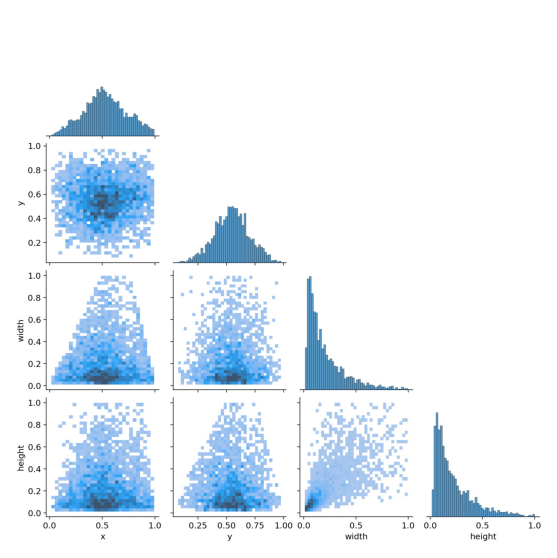

In [76]:
plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(plt.imread('runs/train/exp/labels_correlogram.jpg'));

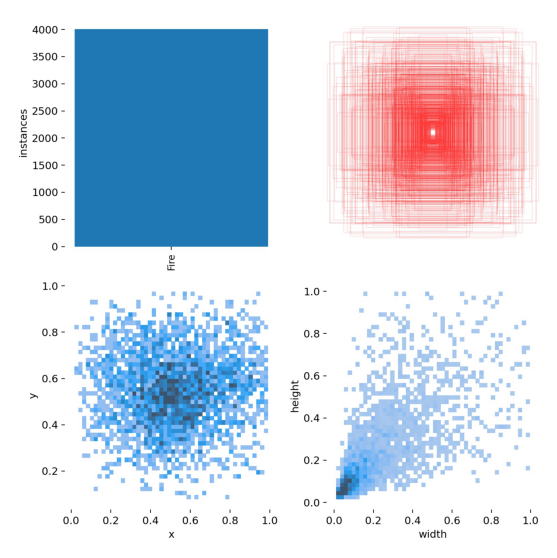

In [77]:
plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(plt.imread('runs/train/exp/labels.jpg'));

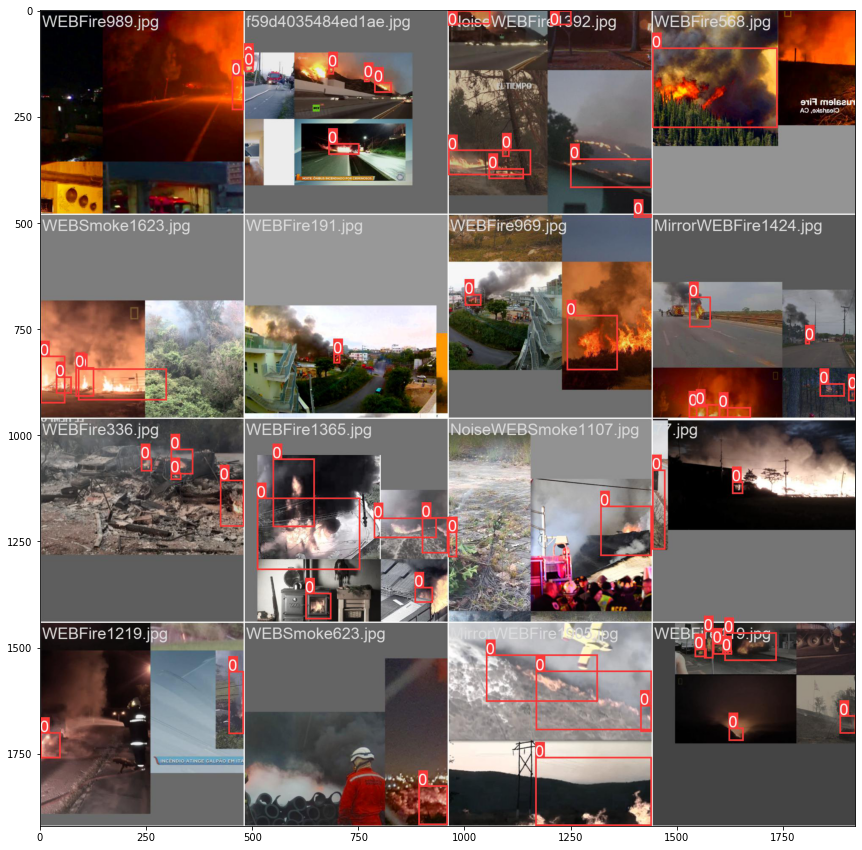

In [79]:
plt.figure(figsize = (15, 15))
plt.imshow(plt.imread('runs/train/exp/train_batch2.jpg'))

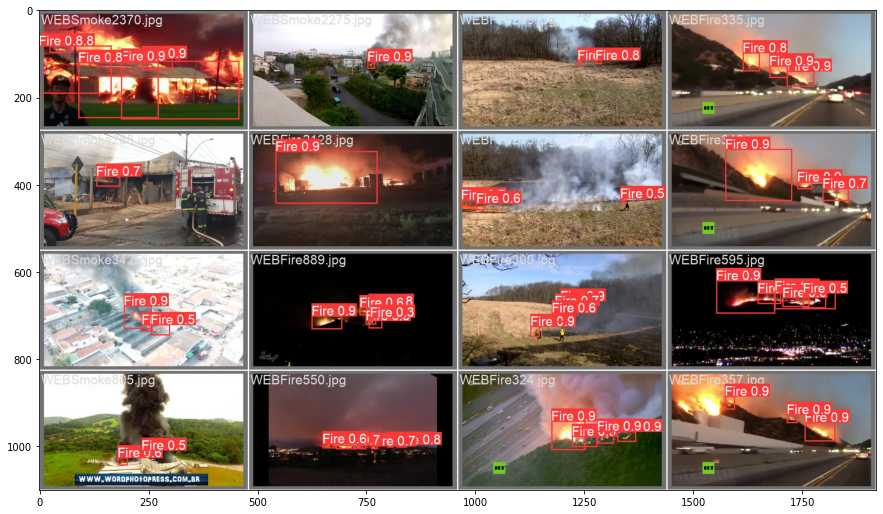

In [80]:
plt.figure(figsize = (15, 15))
plt.imshow(plt.imread(f'runs/train/{os.listdir("runs/train/")[-1]}/val_batch2_pred.jpg'))

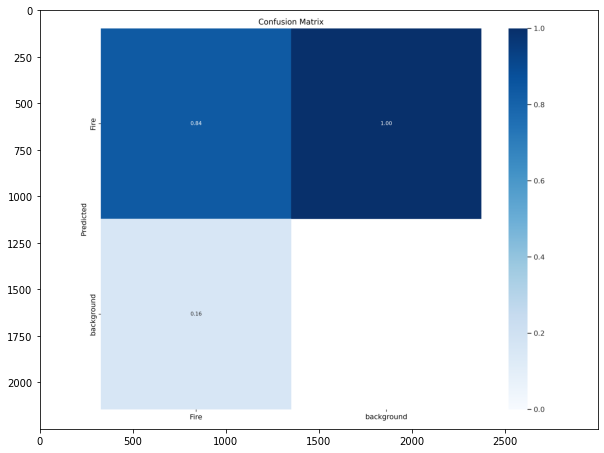

In [81]:
plt.figure(figsize = (10, 10))
plt.imshow(plt.imread(f'runs/train/{os.listdir("runs/train/")[-1]}/confusion_matrix.png'))

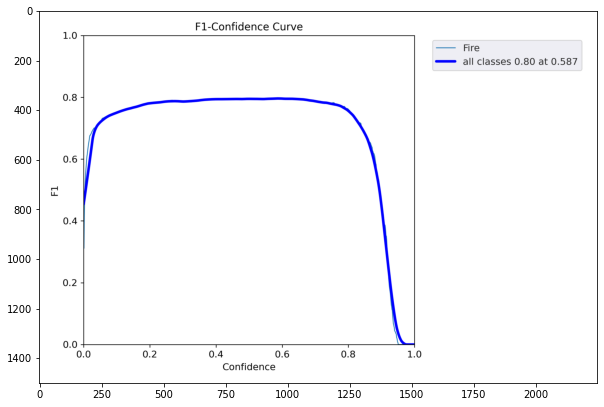

In [82]:
plt.figure(figsize = (10, 10))
plt.imshow(plt.imread(f'runs/train/{os.listdir("runs/train/")[-1]}/F1_curve.png'))

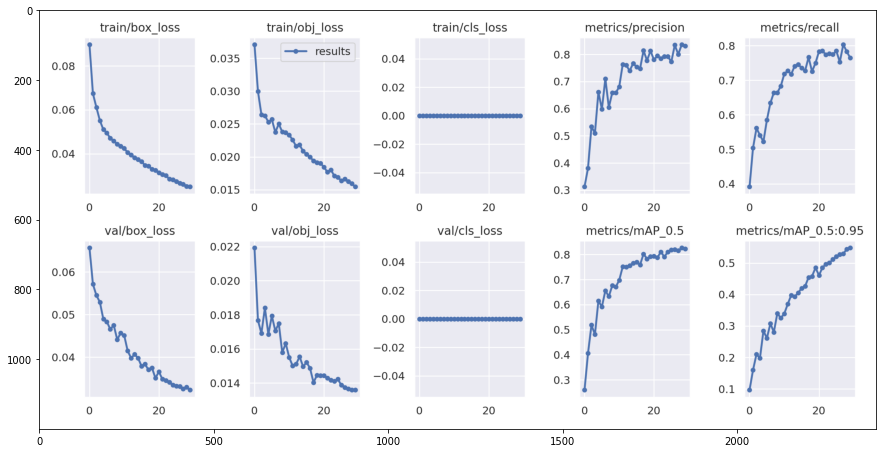

In [83]:
plt.figure(figsize = (15, 15))
plt.imshow(plt.imread(f'runs/train/{os.listdir("runs/train/")[-1]}/results.png'))

### Evaluating
- 
```
!python val.py --weights <PATH TO WEIGHTS> --data <PATH TO DATA CONFIG> --img 640 --iou 0.5 ...
```

In [87]:
!python val.py --exist-ok --weights runs/train/exp/weights/best.pt --data /content/drive/MyDrive/FIRE/yolo/fire.yaml --img 640 --iou 0.5 

val: data=/content/drive/MyDrive/FIRE/yolo/fire.yaml, weights=['runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.5, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=True, half=False, dnn=False
YOLOv5 🚀 v6.2-226-gfde7758 Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 322 layers, 86173414 parameters, 0 gradients, 203.8 GFLOPs
val: Scanning '/content/drive/MyDrive/FIRE/yolo/val.cache' images and labels... 218 found, 0 missing, 0 empty, 3 corrupt: 100% 218/218 [00:00<?, ?it/s]
val: WARNING ⚠️ /content/drive/MyDrive/FIRE/yolo/images/val/347.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0087]
val: WARNING ⚠️ /content/drive/MyDrive/FIRE/yolo/images/val/776.jpg: ignoring corrupt image/label: non-normalized or out of boun

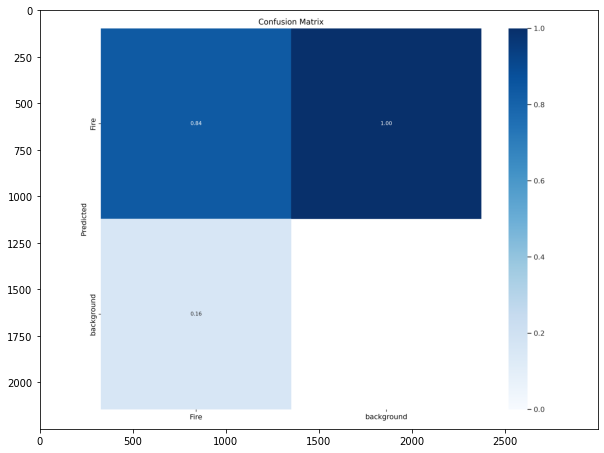

In [88]:
plt.figure(figsize = (10, 10))
plt.imshow(plt.imread(f'runs/val/{os.listdir("runs/val/")[-1]}/confusion_matrix.png'))

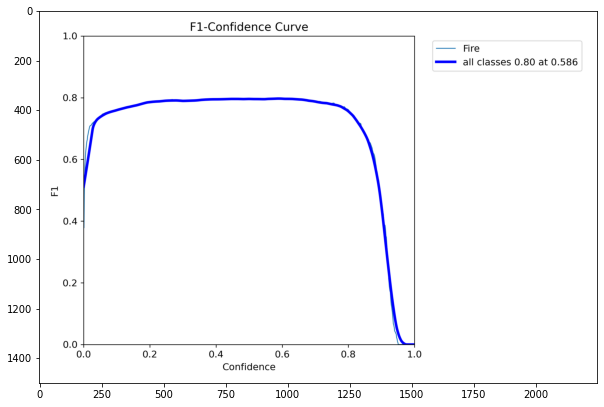

In [89]:
plt.figure(figsize = (10, 10))
plt.imshow(plt.imread(f'runs/val/{os.listdir("runs/val/")[-1]}/F1_curve.png'))

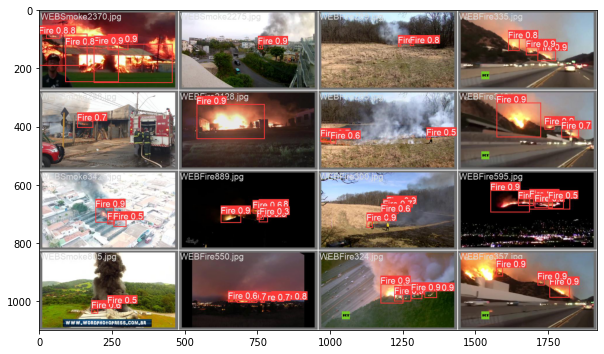

In [90]:
plt.figure(figsize = (10, 10))
plt.imshow(plt.imread(f'runs/train/{os.listdir("runs/val/")[-1]}/val_batch2_pred.jpg'))

### PREDICTING.
- YOu can download the weights you are conformtable with and then user `torch.load` to load the model or 
- You can also use `detect.py` file and paass the image path you want eg.

```
!python detect.py --source <IMG PATH> --weights <WEIGHTS PAHT> --img 640 .. 
```


In [92]:
BEST_WGHT =  f'/content/drive/MyDrive/FIRE/yolo/yolov5/runs/train/exp/weights/best.pt'

In [93]:
import torch


model = torch.hub.load('ultralytics/yolov5', 'custom', path="runs/train/exp/weights/best.pt", force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2022-11-4 Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 322 layers, 86173414 parameters, 0 gradients, 203.8 GFLOPs
Adding AutoShape... 


In [ ]:
# model

In [94]:
test1 =  model("/content/drive/MyDrive/FIRE/images/MirrorWEBSmoke1318.jpg")

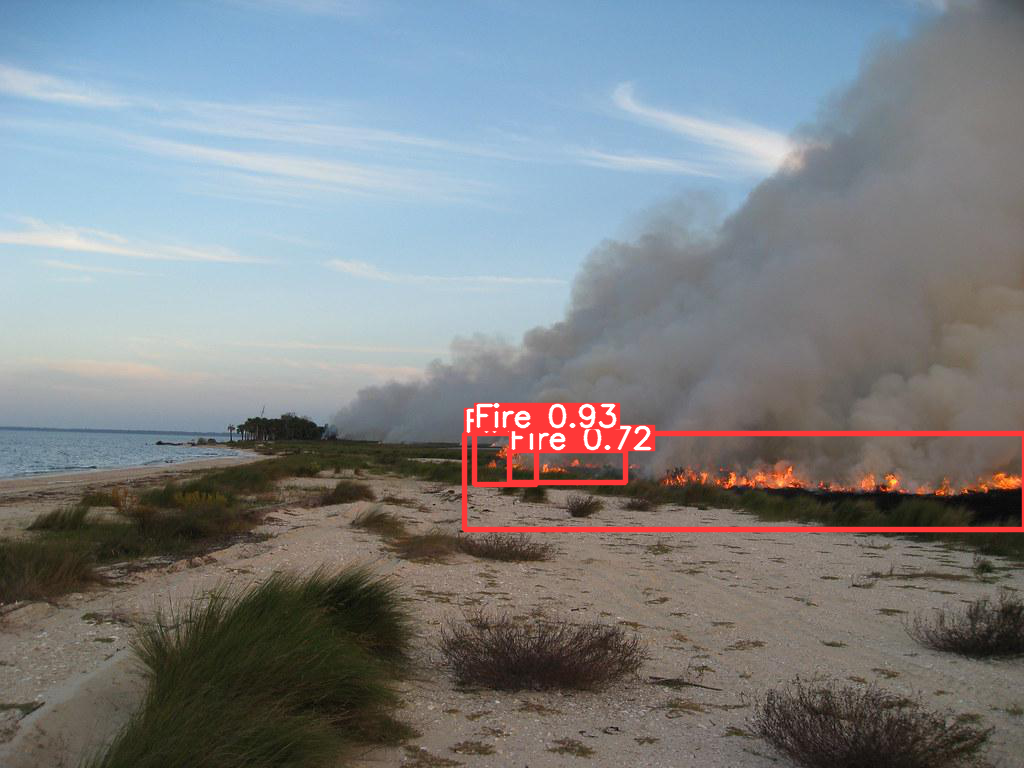

In [95]:
test1.show()

In [96]:
!python detect.py --source /content/drive/MyDrive/FIRE/images/MirrorWEBSmoke1318.jpg --weights runs/train/exp/weights/best.pt --img 640 

detect: weights=['runs/train/exp/weights/best.pt'], source=/content/drive/MyDrive/FIRE/images/MirrorWEBSmoke1318.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v6.2-226-gfde7758 Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 322 layers, 86173414 parameters, 0 gradients, 203.8 GFLOPs
image 1/1 /content/drive/MyDrive/FIRE/images/MirrorWEBSmoke1318.jpg: 480x640 3 Fires, 72.3ms
Speed: 0.6ms pre-process, 72.3ms inference, 1.5ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp


In [97]:
os.listdir("runs/detect/exp")

['MirrorWEBSmoke1318.jpg']

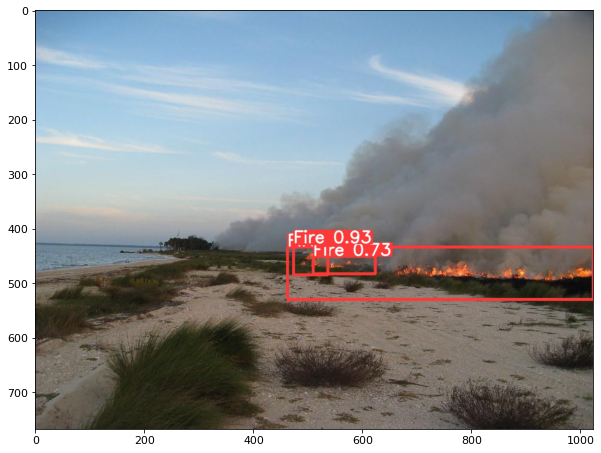

In [100]:
plt.figure(figsize = (10, 10))
plt.imshow(plt.imread(f'runs/detect/exp/MirrorWEBSmoke1318.jpg'))

In [101]:
test2 = model("/content/drive/MyDrive/FIRE/images/WEBFire977.jpg")

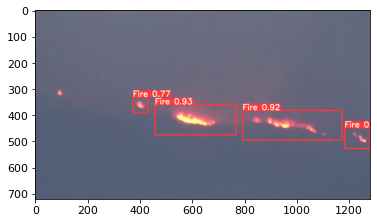

In [102]:
plt.imshow(np.squeeze(test2.render()))

In [103]:
!pwd

/content/drive/MyDrive/FIRE/yolo/yolov5


In [105]:
# !python detect.py --source /content/input.mp4 --weights runs/train/exp/weights/best.pt --conf 0.2

In [106]:
# Inferencing using this code takes alot of time since you have to extract each frame and then pass to model before visualizing

# import cv2
# vidcap = cv2.VideoCapture('runs/detect/exp8/input.mp4')
# success,image = vidcap.read()
# images = []
# while success:
#     success,image = vidcap.read()
#     if success:
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         images.append(image)

In [107]:
# len(images)

In [108]:
# from matplotlib import animation, rc
# import matplotlib.pyplot as plt
# import matplotlib
# matplotlib.rcParams['animation.embed_limit'] = 2**128


# rc('animation', html='jshtml')

# def create_animation(ims):
#     fig = plt.figure(figsize=(9, 9))
#     plt.axis('off')
#     im = plt.imshow(ims[0])

#     def animate_func(i):
#         im.set_array(ims[i])
#         return [im]

#     return animation.FuncAnimation(fig, animate_func, frames = len(ims), interval = 1000//12)

# create_animation(images)

In [ ]:
# ISSUES:
# ....Fire doesn’t have any specified shape or size and even at times, varies in color, 
# Hence achieving a high accuracy in its detection is a difficult task.

### Resources
- https://pyimagesearch.com/2022/06/20/training-the-yolov5-object-detector-on-a-custom-dataset/
- https://universe.roboflow.com/s-p8sfw/my-datasets-dqlz3
- https://github.com/ultralytics/yolov5
- https://medium.com/analytics-vidhya/yolo-explained-5b6f4564f31
- https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data
- https://medium.com/@b117020/fire-detection-using-neural-networks-4d52c5cd55c5